# Prediction of psalms reuses in NT from gold standard

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from tqdm import tqdm
from cmcrameri import cm

color_style = cm.roma # selecting a cyclic color style for the plots

## Load the data

### Gold standard

In [ ]:
GT = pd.read_csv("data/GS_NT-Ps.csv", delimiter='\t',header=0,dtype=str)

# change the book names to match the ones in NT
dict_names = {
    '1 Corinthians':'1Co', 
    '1 Peter':'1P', 
    '2 Corinthians':'2Co',
    '2 Peter': '2P',
    'Acts': 'Ac',
    '2 John': '2Jn',
    '3 John': '3Jn',
    '1 John': '1Jn',
    '2 Timothy': '2Tm',
    '1 Timothy': '1Tm',
    '1 Thessalonians': '1Th',
    '2 Thessalonians': '2Th',
    'Colossians': 'Col',
    'Ephesians': 'Ep',
    'Galatians': 'Ga',
    'Philippians': 'Phi',
    'Hebrews': 'He',
    'John': 'Jn',
    'James': 'Ja',
    'Luke': 'Lk',
    'Mark': 'Mk',
    'Matthew': 'Mt',
    'Revelation':'Re',
    'Romans': 'Ro',
    'Titus': 'Ti',
    'Philemon': 'Phm',
    'Jude': 'Ju',
}

GT['NT_book'] = GT['NT_book'].replace(dict_names)
GT['NT'] = GT.loc[:,'NT_book'] + ' ' + GT.loc[:,'NT_chapter']
GT['Ps'] = GT.loc[:,'Ps'] + ' ' + GT.loc[:,'Ps_chapter']

# delete the columns that are not needed
GT = GT.drop(columns=['NT_chapter','NT_book', 'Ps_chapter'])

GT['Ps_verse_2'] = GT['Ps_verse']

for i in range(len(GT)):
    if '.' in str(GT['Ps_verse'][i]):
        parts = GT['Ps_verse'][i].split('.')
        for j in range(len(parts)):
            GT.loc[i+j*0.1] = GT.loc[i]
            GT.loc[i+j*0.1, 'Ps_verse'] = parts[j]
            GT.loc[i+j*0.1, 'Ps_verse_2'] = parts[j]
      
GT = GT.sort_index().reset_index(drop=True)

for i in range(len(GT)):
    if '-' in str(GT['Ps_verse'][i]):
        parts = GT['Ps_verse'][i].split('-')
        GT.loc[i, 'Ps_verse'] = parts[0]
        GT.loc[i, 'Ps_verse_2'] = parts[1]


GT['NT_verse_2'] = GT['NT_verse']

for i in range(len(GT)):
    if '-' in str(GT['NT_verse'][i]):
        parts = GT['NT_verse'][i].split('-')
        GT.loc[i, 'NT_verse'] = parts[0]
        GT.loc[i, 'NT_verse_2'] = parts[1]

# create a list of integers between GT.loc[i,'NT_verse'] and GT.loc[i,'NT_verse_2'] with a step of 1
def create_verse_range_NT(row):
    start = int(row['NT_verse'])
    end = int(row['NT_verse_2'])
    return list(range(start, end + 1))
GT['NT_verse_range'] = GT.apply(create_verse_range_NT, axis=1)

def create_verse_range_Ps(row):
    start = int(row['Ps_verse'])
    end = int(row['Ps_verse_2'])
    return list(range(start, end + 1))
GT['Ps_verse_range'] = GT.apply(create_verse_range_Ps, axis=1)

GT = GT.drop(columns=['NT_verse', 'NT_verse_2', 'Ps_verse', 'Ps_verse_2'])
GT = GT[['NT', 'NT_verse_range', 'Ps', 'Ps_verse_range','Typology 1', 'Typology 2', 'Typology 3', 'Typology 4','Source']]

display(GT)

,NT,NT_verse_range,Ps,Ps_verse_range,Typology 1,Typology 2,Typology 3,Typology 4,Source
0,He 11,[26],Ps 88,[51],coincidence,implicit,lexical,NaN,NaN
1,Ac 14,[15],Ps 41,[3],coincidence,implicit,litteral,with //,NaN
2,Ac 10,[36],Ps 106,[20],echo,implicit,litteral,NaN,NaN
3,Re 19,[5],Ps 134,[20],echo,implicit,thematicand semantic,"among other verses, motive resumption",NaN
4,1Co 11,[24],Ps 37,[1],coincidence,implicit,lexical,NaN,NaN
...,...,...,...,...,...,...,...,...,...
677,Ro 10,[7],Ps 106,[26],echo,implicit,thematicand semantic,among other verses,NaN
678,Ro 1,[16],Ps 118,[46],echo,implicit,thematicand semantic,among other verses,NaN
679,Ro 3,[21],Ps 70,"[15, 16]",echo,implicit,thematicand semantic,among other verses,NaN
680,Tite 1,[16],Ps 13,[1],echo,implicit,thematicand semantic,"distant, among other verses",NaN


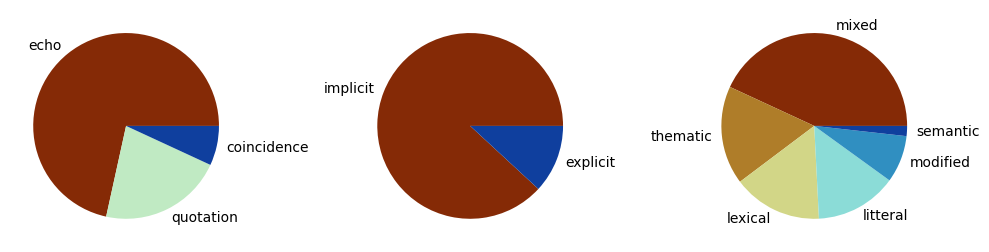

In [ ]:
# Gold standard typology graphs
GT_chart = GT.copy()

GT_chart['Typology 3'] = GT_chart['Typology 3'].replace('thematic and semantic', 'mixed')
GT_chart['Typology 3'] = GT_chart['Typology 3'].replace('thematic and lexical', 'mixed')

# plot charts for each typology
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for i, s in enumerate(['Typology 1', 'Typology 2', 'Typology 3']):
    counts = GT_chart[s].value_counts()
    parts = counts / len(GT_chart)
    axs[i].pie(parts.values, labels=parts.index, colors=cm.roma(np.linspace(0.03, 0.97, len(parts))))
plt.tight_layout()
plt.show()

# save the figure
fig.savefig('typology_distribution_pie_charts.pdf')

### Intertext embedding

In [ ]:
embedding = pickle.load(open("distance_matrices/NT-Ps_embedding.pkl","rb"))
print(embedding.shape)

(24555327, 30)


## Preprocessing

### Preprocessing embedding

In [ ]:
n_features = 16
feat_1 = 8 # position of the first feature column in the dataframe
features_positions = list(range(feat_1, feat_1+n_features)) # positions of the features in the dataframe

# If not already done during the creation of the embedding :
# handle inf in all columns by replacing them with the mean of the column
for col in embedding.columns[feat_1:(feat_1+n_features)]:
    ids = np.isinf(embedding[col])
    mean_value = embedding.loc[~ids, col].mean()
    embedding.loc[ids, col] = mean_value
    print(col, " : ", ids.sum(), " inf values replaced")
# handle NaN in all columns by replacing them with the mean of the column
for col in embedding.columns[feat_1:(feat_1+n_features)]:
    ids = np.isnan(embedding[col])
    mean_value = embedding.loc[~ids, col].mean()
    embedding.loc[ids, col] = mean_value
    print(col, " : ", ids.sum(), " NaN values replaced")

token 1  :  0  inf values replaced
lemma 1  :  0  inf values replaced
PoS 1  :  0  inf values replaced
stop_words 1  :  0  inf values replaced
lemma_filtered 1  :  0  inf values replaced
lexicon 1  :  0  inf values replaced
domain 1  :  0  inf values replaced
subdomain 1  :  0  inf values replaced
token 2  :  0  inf values replaced
lemma 2  :  0  inf values replaced
PoS 2  :  0  inf values replaced
stop_words 2  :  0  inf values replaced
lemma_filtered 2  :  0  inf values replaced
lexicon 2  :  0  inf values replaced
domain 2  :  0  inf values replaced
subdomain 2  :  0  inf values replaced
token 1  :  0  NaN values replaced
lemma 1  :  0  NaN values replaced
PoS 1  :  0  NaN values replaced
stop_words 1  :  0  NaN values replaced
lemma_filtered 1  :  0  NaN values replaced
lexicon 1  :  0  NaN values replaced
domain 1  :  0  NaN values replaced
subdomain 1  :  0  NaN values replaced
token 2  :  0  NaN values replaced
lemma 2  :  0  NaN values replaced
PoS 2  :  0  NaN values replaced


In [ ]:
embedding['NT_range'] = embedding['NT_range'].apply(lambda x: str(x) if isinstance(x, list) else x)
embedding['Ps_range'] = embedding['Ps_range'].apply(lambda x: str(x) if isinstance(x, list) else x)

## Prediction of Psalmic reuse in NT

### Prediction computation

In [ ]:
methods = embedding.columns[features_positions].tolist()

for method in tqdm(methods, desc="Overall Progress", unit="method"):
    embedding_sorted = embedding.sort_values(by=method)

    def get_top_predictions(row):
        v = row['verses']            # list of "NT,verse" strings
        r = int(row['ref_count'])
        if r <= 0:
            return []
        mask = embedding_sorted['NT'].isin(v)

        res = embedding_sorted.loc[mask, 'Ps'].head(r).tolist()

        # drop duplicates in res list
        seen = set()
        res_2 = [x for x in res if not (x in seen or seen.add(x))]
     
        return res_2

    nearest_verses_Ps = GT[['verses', 'ref_count']].apply(get_top_predictions, axis=1).tolist()

    colname = 'predicted_' + method
    GT[colname] = [[] for _ in range(len(GT))]  # initialize empty lists
    GT[colname].values[:] = nearest_verses_Ps

Overall Progress: 100%|██████████| 16/16 [34:06<00:00, 127.91s/method]


#### Predictions scores

In [15]:
# for each prediction column in GT (columns that start with 'predicted_'), create a corresponding boolean result column
pred_cols = [c for c in GT.columns if c.startswith('predicted_')]

for pred_col in pred_cols:
    res_col = pred_col.replace('predicted_', 'result_')
    GT[res_col] = False  # initialize
    
    for i in range(len(GT)):
        # build set of true Ps verse identifiers for faster membership checks
        ps_range = GT.at[i, 'Ps_verse_range']
        ps_label = GT.at[i, 'Ps']
        try:
            Ps_set = {f"{ps_label},{j}" for j in ps_range}
        except Exception:
            Ps_set = set()
        
        preds = GT.at[i, pred_col]
        if not preds:
            continue
        # ensure preds is iterable
        try:
            for item in preds:
                if item in Ps_set:
                    GT.at[i, res_col] = True
                    break
        except Exception:
            # if preds is not iterable or unexpected, skip
            continue

# compute an overall result column that is True if any of the individual result columns is True
result_cols = [c for c in GT.columns if c.startswith('result')]
GT['overall_result'] = GT[result_cols].any(axis=1)

# compute the accuracy of the prediction
accuracy = GT['overall_result'].sum() / len(GT)
print("Accuracy of the prediction: ", accuracy)

display(GT)

Accuracy of the prediction:  0.49266862170087977


,NT,NT_verse_range,Ps,Ps_verse_range,Typology 1,Typology 2,Typology 3,Typology 4,Source,verses,...,result_subdomain 1,result_token 2,result_lemma 2,result_PoS 2,result_stop_words 2,result_lemma_filtered 2,result_lexicon 2,result_domain 2,result_subdomain 2,overall_result
0,1Co 10,[26],Ps 23,[1],quotation,implicit,litteral,NaN,PNT Swete NA,"[1Co 10,26]",...,False,True,True,False,False,True,True,True,False,True
1,1Co 15,[25],Ps 109,[1],quotation,implicit,modified,NaN,PNT NA,"[1Co 15,25]",...,False,False,False,False,False,False,True,False,False,True
2,1Co 3,[17],Ps 78,[1],echo,implicit,thematic,"distant, among other verses",NaN,"[1Co 3,17]",...,False,False,False,False,False,False,True,False,False,True
3,1Co 11,[24],Ps 37,[1],coincidence,implicit,lexical,NaN,NaN,"[1Co 11,24]",...,False,False,False,False,False,False,False,False,False,False
4,1Co 11,[24],Ps 69,[1],coincidence,implicit,lexical,distant,NaN,"[1Co 11,24]",...,False,True,True,False,False,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,Ro 3,"[10, 11]",Ps 52,"[3, 4]",quotation,explicit,litteral,NaN,PNT NA,"[Ro 3,10, Ro 3,11]",...,False,True,False,False,False,True,True,True,True,True
678,Ro 3,[4],Ps 50,"[5, 6, 7]",quotation,explicit,litteral,NaN,PNT Swete NA,"[Ro 3,4]",...,True,True,True,False,False,True,True,False,False,True
679,Ro 15,[9],Ps 17,"[50, 51]",quotation,explicit,litteral,NaN,PNT Swete NA,"[Ro 15,9]",...,False,True,True,False,False,True,False,False,False,True
680,Tite 1,[16],Ps 13,[1],echo,implicit,thematicand semantic,"distant, among other verses",NaN,"[Tite 1,16]",...,False,False,False,False,False,False,False,False,False,False


#### Export in csv

In [ ]:
# export GT to a csv file
GT.to_csv("data/Ps_reuses_predictions.csv", sep='\t', index=False)

### Prediction results analysis

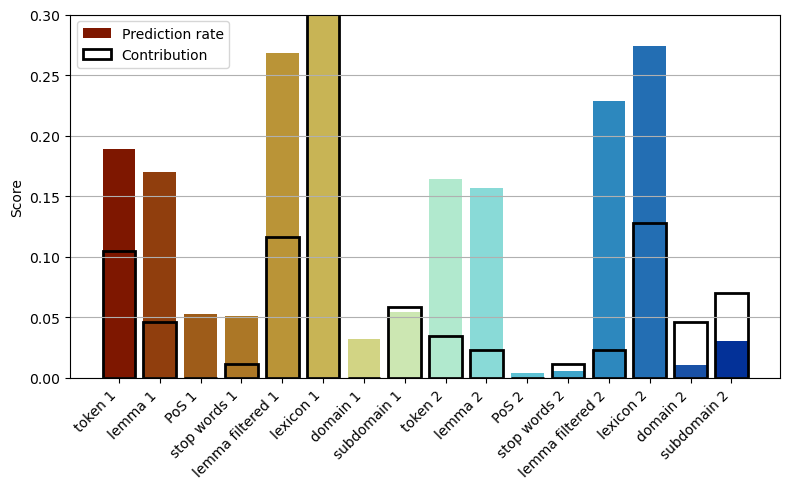

In [ ]:
id_single_true = [i for i in range(len(GT)) if GT.loc[i, 'overall_result'] == True and sum(GT.loc[i, col] for col in result_cols) == 1]

# plot the accuracy for each method
accuracies = {}
contributions = {}
for pred_col in pred_cols:
    res_col = pred_col.replace('predicted_', 'result_')
    acc = GT[res_col].sum() / len(GT)
    method_name = pred_col.replace('predicted_', '').replace('_', ' ')    
    accuracies[method_name] = acc
    correct_single_true = sum(1 for i in id_single_true if GT.loc[i, res_col] == True)
    contributions[method_name] = correct_single_true / len(id_single_true) if len(id_single_true) > 0 else 0.0

fig = plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color=color_style(np.linspace(0, 1, len(accuracies))), alpha=1,label='Prediction rate')

# plot contributions in the same figure with only a contour
plt.bar(contributions.keys(), contributions.values(), edgecolor='black', linewidth=2, facecolor='none', label='Contribution')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Score')
plt.ylim(0, 0.3)
plt.grid(axis='y')
plt.legend()
plt.tight_layout()
plt.show()

# save the figure in pdf
fig.savefig("Ps_reuses_predictions_representations.pdf")

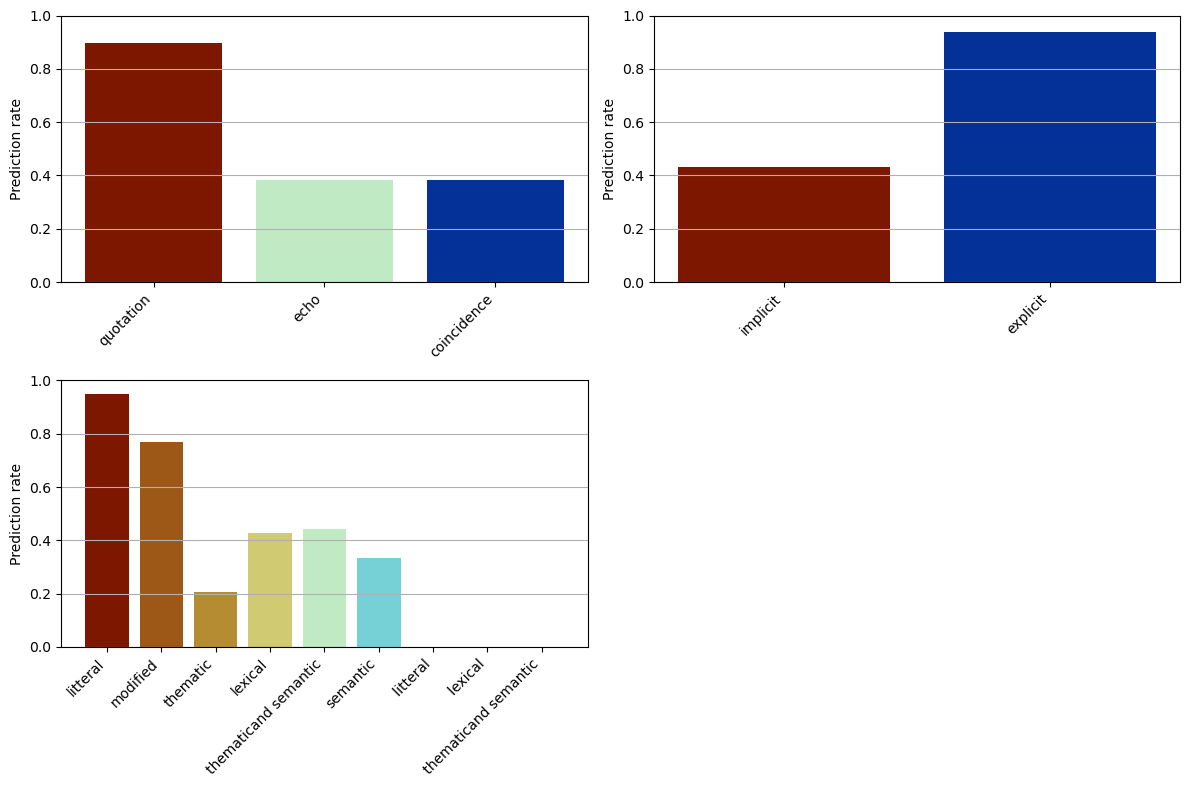

In [ ]:
# plot the repartition of typology in function of the accuracy
typology_cols = ['Typology 1', 'Typology 2', 'Typology 3']
typology_accuracy = {col: {} for col in typology_cols}
for col in typology_cols:
    for val in GT[col].unique():
        if pd.isna(val):
            continue
        subset = GT[GT[col] == val]
        if len(subset) == 0:
            continue
        acc = subset['overall_result'].sum() / len(subset)
        typology_accuracy[col][val] = acc

fig = plt.figure(figsize=(12, 8))
for i, col in enumerate(typology_cols):
    plt.subplot(2, 2, i+1)
    if typology_accuracy[col]:
        plt.bar(typology_accuracy[col].keys(), typology_accuracy[col].values(), color=color_style(np.linspace(0, 1, len(typology_accuracy[col]))))
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Prediction rate')
    plt.ylim(0, 1)
    plt.grid(axis='y')
plt.tight_layout()
plt.show()

fig.savefig("Ps_reuses_predictions_typology.pdf")